In [74]:
import pandas as pd
import torch
import torch.nn as nn
# import vaex
import numpy as np
import glob
import dask.dataframe as dd
import json
from sklearn.model_selection import train_test_split
import math
import csv
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, classification_report, confusion_matrix
import time
import _warnings
from tqdm import tqdm
import swifter
import argparse
import os
from copy import copy, deepcopy
from pathlib import Path
from concurrent import futures
from functools import partial
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time

mpl.rcParams.update(mpl.rcParamsDefault)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.weight": "bold"
})

In [2]:
from collections import Counter
from matplotlib import pyplot
from numpy import where
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import KMeansSMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.cluster import MiniBatchKMeans

epochs_number = 1  # number of epochs for the neural networks
test_set_size = 0.2  # percentage of the test size comparing to the whole dataset
oversampling_flag = 1  # set to 1 to over-sample the minority class
oversampling_percentage = 0.2  # percentage of the minority class after the oversampling comparing to majority class

# PREPROCESSING

In [3]:
# Step 1: Load the data

raw_data = pd.read_csv('../data/data.csv')

info_data = pd.DataFrame()
info_data['FLAG'] = raw_data['FLAG']
info_data['CONS_NO'] = raw_data['CONS_NO']

handling_data = raw_data.drop(['FLAG', 'CONS_NO'], axis=1)
# handling_data = raw_data.copy(deep=True)

# Convert column names to datetime
handling_data.columns = pd.to_datetime(handling_data.columns)

# Sort columns
handling_data = handling_data.sort_index(axis=1)
handling_data

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
42368,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,5.68,4.39,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
42369,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,1.23,0.84,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65
42370,16.89,15.15,19.28,17.19,16.80,17.48,17.86,23.99,12.34,13.84,...,15.64,16.48,13.04,10.39,12.00,11.15,12.22,13.16,13.33,10.39


In [4]:
rawData = pd.read_csv('../data/data.csv')

#data preprocessing 
infoData = pd.DataFrame()
infoData['FLAG'] = rawData['FLAG']
infoData['CONS_NO'] = rawData['CONS_NO']
data = rawData.drop(['FLAG', 'CONS_NO'], axis=1)   #axis 1 column ,axis 0 row

#droping duplicate row
dropIndex = data[data.duplicated()].index  # duplicates drop
data = data.drop(dropIndex, axis=0)   #droping duplicate value present wen two row are same
infoData = infoData.drop(dropIndex, axis=0) #droping duplicate index infodata

#removing row with all zero(Nan) value
zeroIndex = data[(data.sum(axis=1) == 0)].index  # zero rows drop
data = data.drop(zeroIndex, axis=0) 
infoData = infoData.drop(zeroIndex, axis=0)  

#change column name to dates(2014/1/1 to 2014-01-01)
data.columns = pd.to_datetime(data.columns)  #columns reindexing according to dates

#sort data accoding to date( as previusoly column are unsorted)
data = data.reindex(sorted(data.columns), axis=1)
cols = data.columns

# reindex row name (as some row has been remove till this step due to duplicate or all nan values)
data.reset_index(inplace=True, drop=True)  # index sorting
infoData.reset_index(inplace=True, drop=True)

#filling nan value using neighbouring value (middle missing value replace by average 
#and other by maximum 2 distance element)
data = data.interpolate(method='linear', limit=2, limit_direction='both', axis=0).fillna(0) 


#removing erronoues value(fixing outliers)
for i in range(data.shape[0]):  # outliers treatment
    m = data.loc[i].mean()
    st = data.loc[i].std()
    data.loc[i] = data.loc[i].mask(data.loc[i] > (m + 3 * st), other=m + 3 * st)
    
data


,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0.000,0.000,0.00,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,2.900,5.640,6.99,3.320,3.610000,5.350,4.730000,3.680000,3.530000,3.420000,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
2,2.900,5.640,6.99,3.320,3.610000,5.350,4.730000,3.680000,3.530000,3.420000,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
3,2.900,5.640,6.99,3.320,3.610000,5.350,4.730000,3.680000,3.530000,3.420000,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
4,1.505,2.875,3.62,1.795,1.910000,2.775,2.435000,2.010000,1.880000,1.975000,...,2.51,2.97,2.93,0.74,0.41,0.42,1.91,0.42,0.38,0.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40251,3.540,1.680,1.64,5.440,8.563333,7.450,3.646667,4.806667,6.143333,2.926667,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
40252,2.700,0.000,0.00,5.720,6.050000,5.810,3.070000,4.040000,5.680000,4.390000,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
40253,0.580,1.160,0.92,0.980,1.540000,1.380,0.890000,0.700000,1.230000,0.840000,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65
40254,16.890,15.150,19.28,17.190,16.800000,17.480,17.860000,23.990000,12.340000,13.840000,...,15.64,16.48,13.04,10.39,12.00,11.15,12.22,13.16,13.33,10.39


In [5]:
# Step 2: Data Cleaning

## Giá trị ban đầu là 31683 nhưng khi sort theo date trước thì chỉ còn 31355

threshold = 600  # Set the threshold for NaN values

# remove duplicates rows
dropIndex = handling_data[handling_data.duplicated()].index  
handling_data = handling_data.drop(dropIndex, axis=0)
info_data = info_data.drop(dropIndex, axis=0)

# zeroIndex = handling_data[(handling_data.sum(axis=1) == 0)].index  # remove all zero rows 
# handling_data = handling_data.drop(zeroIndex, axis=0)

# Get index of rows with more than 600 NaNs
overthreshhold_index = handling_data[handling_data.isnull().sum(axis=1) > threshold].index  
handling_data = handling_data.drop(overthreshhold_index)
info_data = info_data.drop(overthreshhold_index, axis=0)

handling_data.reset_index(inplace=True, drop=True)  # index sorting
info_data.reset_index(inplace=True, drop=True)
handling_data

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
2,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
3,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
4,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
31351,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
31352,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,5.68,4.39,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
31353,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,1.23,0.84,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65


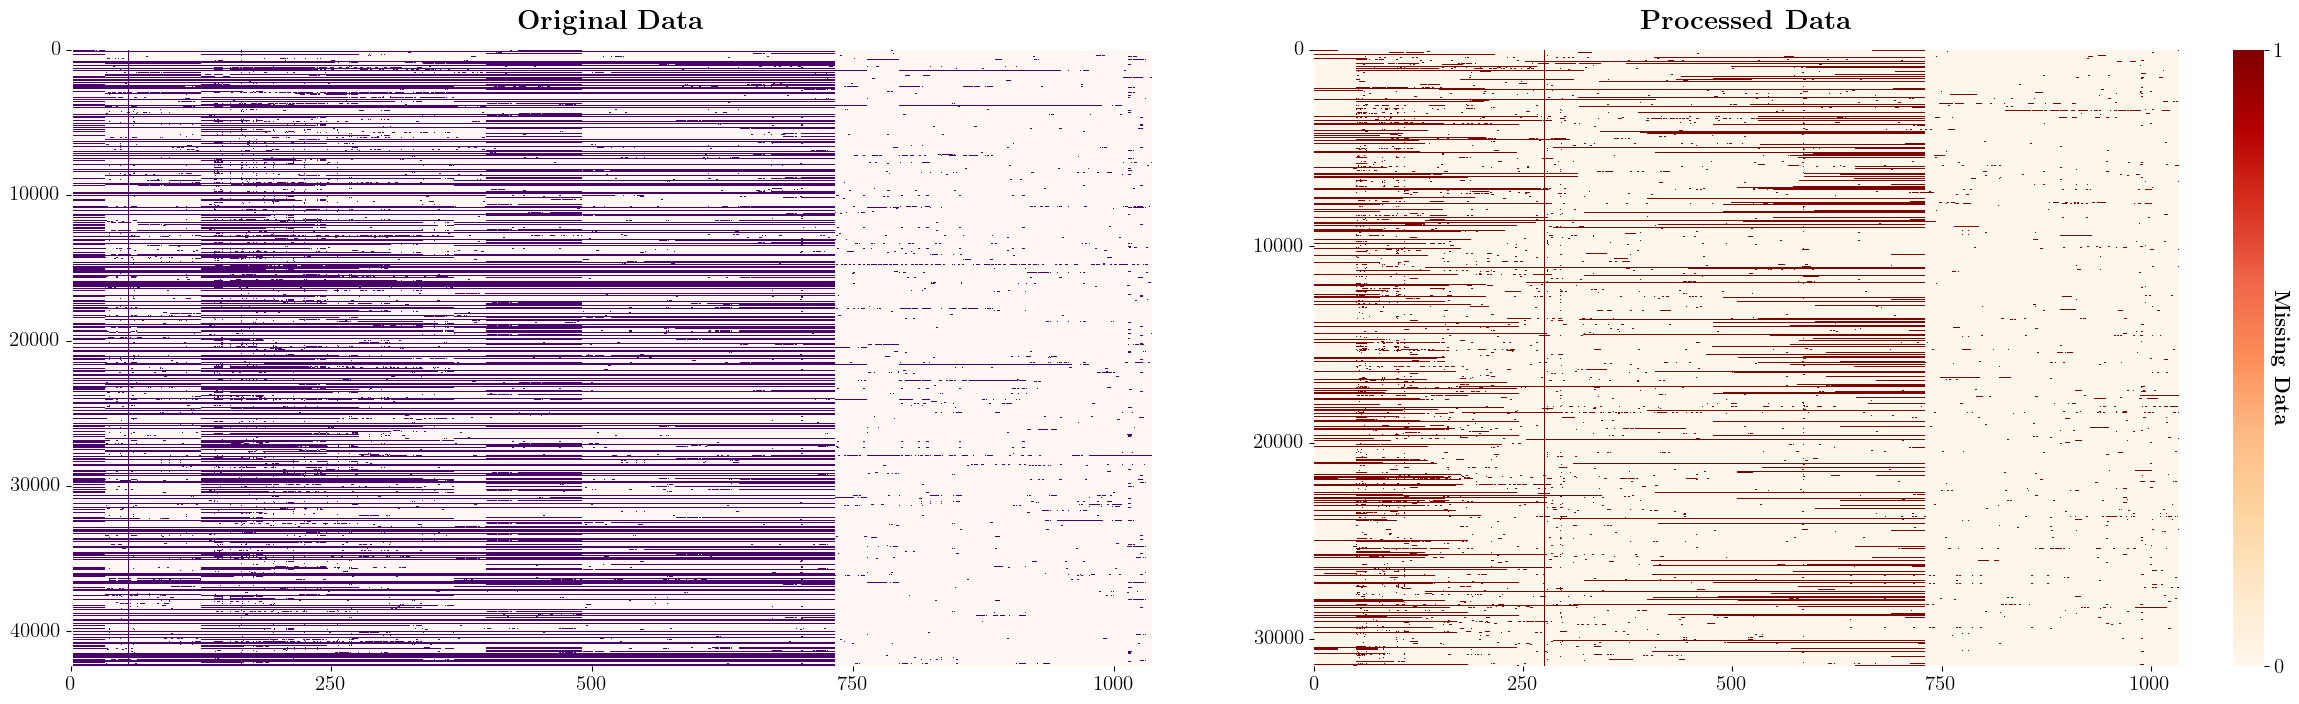

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(30,8))

sns.heatmap(raw_data.transpose().isna().transpose(),
            cmap="RdPu", ax=axs[0], cbar=False)
axs[0].set_title(r'\textbf{Original Data}', fontsize=20, y=1.02)
axs[0].set_xticks([0, 250, 500,750,1000])
axs[0].set_xticklabels([0, 250, 500,750,1000], rotation=0, fontsize=15)
axs[0].set_yticks([0,10000, 20000, 30000, 40000])
axs[0].set_yticklabels([0, 10000, 20000, 30000, 40000], fontsize=15)

# cmap="OrRd"
cbar_ax = sns.heatmap(handling_data.transpose().isna().transpose(),
            cmap="OrRd",
            cbar_kws={"ticks":[0,1]}, ax=axs[1]).collections[0].colorbar

# Set the label size of the colorbar
cbar_ax.ax.yaxis.set_tick_params(labelsize=15)
cbar_ax.set_label(r'\textbf{Missing Data}', rotation=-90, size=15)

axs[1].set_title(r'\textbf{Processed Data}', fontsize=20, y=1.02)
axs[1].set_xticks([0, 250, 500,750,1000])
axs[1].set_xticklabels([0, 250, 500,750,1000], rotation=0, fontsize=15)
axs[1].set_yticks([0,10000, 20000,30000])
axs[1].set_yticklabels([0,10000, 20000,30000], fontsize=15)

plt.subplots_adjust(wspace=0.15)
plt.show()

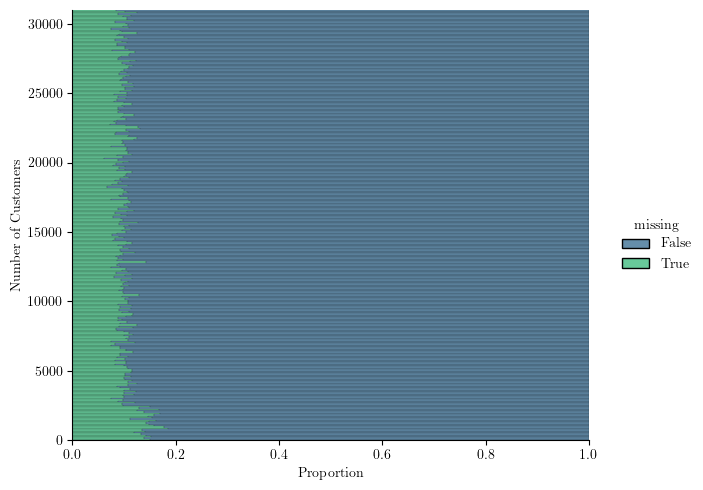

In [8]:
b=sns.displot(
    data=handling_data.transpose().isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25,
    palette="viridis"
)
# b.set_xticklabels(size = 12)
# b.set_yticklabels(size = 12)
plt.xlabel('Proportion')
plt.ylabel('Number of Customers')
plt.ylim([0,31000])
plt.show()
# plt.savefig('missing_P.png')


In [6]:
balancing_data = handling_data.copy(deep=True)
balancing_data

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
2,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
3,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
4,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
31351,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
31352,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,5.68,4.39,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
31353,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,1.23,0.84,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65


### Fill the missing values

In this work, we exploit the interpolation method to recover the missing values according to the following equation,

\begin{equation}
f(x_i)=
\begin{cases}
\frac{x_{i-1}+x_{i+1}}{2} \quad  x_i \in NaN,\;x_{i-1},x_{i+1} \notin NaN \\
0 \quad\quad\quad \;  x_i \in NaN,\;x_{i-1}\;or\; x_{i+1} \in NaN \\
x_i \quad \quad \quad  x_i \notin NaN
\end{cases}
\end{equation}

The interpolate() function uses existing values in the DataFrame to estimate the missing rows.

In [7]:
balancing_data = balancing_data.interpolate(method='linear', limit=2, limit_direction='both', axis=0).fillna(0) 
# balancing_data = balancing_data.interpolate(method='linear', limit=2,  # filling NaN values
#                         limit_direction='both', axis=0).fillna(0)
balancing_data

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,2.90,5.64,6.99,3.32,3.610000,5.35,4.730000,3.680000,3.530000,3.420000,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,2.90,5.64,6.99,3.32,3.610000,5.35,4.730000,3.680000,3.530000,3.420000,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
2,2.90,5.64,6.99,3.32,3.610000,5.35,4.730000,3.680000,3.530000,3.420000,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
3,0.11,0.11,0.25,0.27,0.210000,0.20,0.140000,0.340000,0.230000,0.530000,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
4,0.91,1.16,0.75,1.30,0.740000,0.94,0.850000,1.210000,1.170000,0.860000,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31350,4.38,3.36,3.28,5.16,11.076667,9.09,4.223333,5.573333,6.606667,1.463333,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
31351,3.54,1.68,1.64,5.44,8.563333,7.45,3.646667,4.806667,6.143333,2.926667,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
31352,2.70,0.00,0.00,5.72,6.050000,5.81,3.070000,4.040000,5.680000,4.390000,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
31353,0.58,1.16,0.92,0.98,1.540000,1.38,0.890000,0.700000,1.230000,0.840000,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65


### Handling the outliers

We restore the value by following equation according to "Three-sigma rule of dumb"

\begin{equation}
f(x_i)=
\begin{cases}
avg(\mathbf{x})+2\cdot std(\mathbf{x}) \quad  if \; x_i > avg(\mathbf{x})+2\cdot std(\mathbf{x})\\
x_i \quad \quad \quad otherwise
\end{cases}
\end{equation}

In [8]:
for i in range(balancing_data.shape[0]):  # outliers treatment
    m = balancing_data.loc[i].mean()
    st = balancing_data.loc[i].std()
    balancing_data.loc[i] = balancing_data.loc[i].mask(balancing_data.loc[i] > (m + 3 * st), other=m + 3 * st)
balancing_data

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,2.90,5.64,6.99,3.32,3.610000,5.35,4.730000,3.680000,3.530000,3.420000,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,2.90,5.64,6.99,3.32,3.610000,5.35,4.730000,3.680000,3.530000,3.420000,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
2,2.90,5.64,6.99,3.32,3.610000,5.35,4.730000,3.680000,3.530000,3.420000,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
3,0.11,0.11,0.25,0.27,0.210000,0.20,0.140000,0.340000,0.230000,0.530000,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
4,0.91,1.16,0.75,1.30,0.740000,0.94,0.850000,1.210000,1.170000,0.860000,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31350,4.38,3.36,3.28,5.16,11.076667,9.09,4.223333,5.573333,6.606667,1.463333,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
31351,3.54,1.68,1.64,5.44,8.563333,7.45,3.646667,4.806667,6.143333,2.926667,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
31352,2.70,0.00,0.00,5.72,6.050000,5.81,3.070000,4.040000,5.680000,4.390000,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
31353,0.58,1.16,0.92,0.98,1.540000,1.38,0.890000,0.700000,1.230000,0.840000,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65


In [23]:
deff = pd.read_csv("../data/new_clean_data2.csv").drop(['Unnamed: 0'], axis=1)
deff

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
2,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
3,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
4,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31678,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
31679,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
31680,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,5.68,4.39,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
31681,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,1.23,0.84,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65


In [ ]:
balancing_data.to_csv(r'../data/visualization.csv', index=False, header=True)  # preprocessed data without scaling

In [9]:
preprData = pd.concat([info_data, balancing_data], axis=1, sort=False)  # Back to initial format
# print(preprData)
preprData.to_csv(r'../data/processed_data.csv', index=False, header=True)

In [10]:
scale = MinMaxScaler()
scaled = scale.fit_transform(balancing_data.values.T).T
mData = pd.DataFrame(data=scaled, columns=balancing_data.columns)
# print(mData)
preprData = pd.concat([info_data, mData], axis=1, sort=False)  # Back to initial format
# print(preprData)
preprData.to_csv(r'../data/processed_data.csv', index=False, header=True)

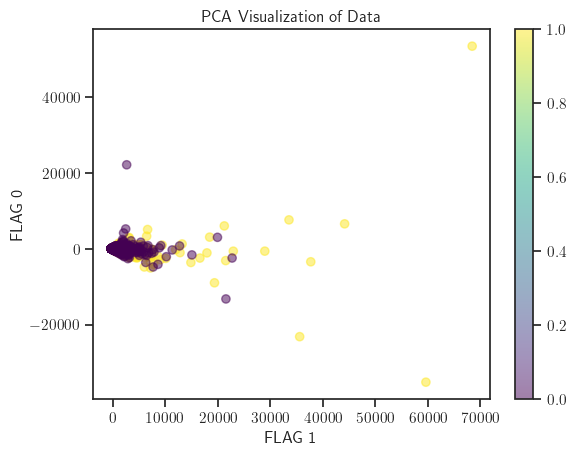

In [45]:
# Performing PCA to reduce the dimensionality of x for visualization
pca = PCA(n_components=2)
x_pca = pca.fit_transform(balancing_data)

# Ensure that the number of labels in y matches the number of data points in x_pca
assert len(x_pca) == len(info_data['FLAG']), "The number of data points in x_pca does not match the number of labels in y."

# Plotting the reduced x in 2D
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=info_data['FLAG'], cmap='viridis', alpha=0.5)
plt.xlabel('FLAG 1')
plt.ylabel('FLAG 0')
plt.title('PCA Visualization of Data')
plt.colorbar()
plt.show()

In [47]:
preprData

,FLAG,CONS_NO,2014-01-01 00:00:00,2014-01-02 00:00:00,2014-01-03 00:00:00,2014-01-04 00:00:00,2014-01-05 00:00:00,2014-01-06 00:00:00,2014-01-07 00:00:00,2014-01-08 00:00:00,...,2016-10-22 00:00:00,2016-10-23 00:00:00,2016-10-24 00:00:00,2016-10-25 00:00:00,2016-10-26 00:00:00,2016-10-27 00:00:00,2016-10-28 00:00:00,2016-10-29 00:00:00,2016-10-30 00:00:00,2016-10-31 00:00:00
0,1,0387DD8A07E07FDA6271170F86AD9151,2.90,5.64,6.99,3.32,3.610000,5.35,4.730000,3.680000,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,1,B32AC8CC6D5D805AC053557AB05F5343,2.90,5.64,6.99,3.32,3.610000,5.35,4.730000,3.680000,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
2,1,EDFC78B07BA2908B3395C4EB2304665E,2.90,5.64,6.99,3.32,3.610000,5.35,4.730000,3.680000,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
3,1,34C1954AA3703C4F8BD8EAEA7C4B7B83,0.11,0.11,0.25,0.27,0.210000,0.20,0.140000,0.340000,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
4,1,768309B0EB11FD436CEE5ABFB84F4C0C,0.91,1.16,0.75,1.30,0.740000,0.94,0.850000,1.210000,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31350,0,5FCE503B6B616D5023B3C46173383107,4.38,3.36,3.28,5.16,11.076667,9.09,4.223333,5.573333,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
31351,0,F1472871E1AFF49D4289564B6377D76C,3.54,1.68,1.64,5.44,8.563333,7.45,3.646667,4.806667,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
31352,0,F3C8BBCD2DC26C1E0249DEEF6A4256B7,2.70,0.00,0.00,5.72,6.050000,5.81,3.070000,4.040000,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
31353,0,A9A0FE83467A680FBFB0DBFC910DF227,0.58,1.16,0.92,0.98,1.540000,1.38,0.890000,0.700000,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65


Normal Consumers:                     28824
Consumers with Fraud:                 2531
Total Consumers:                      31355
Classification assuming no fraud:     91.93 %
Test set assuming no fraud:           91.81 %

Counter({0: 1090, 1: 86})


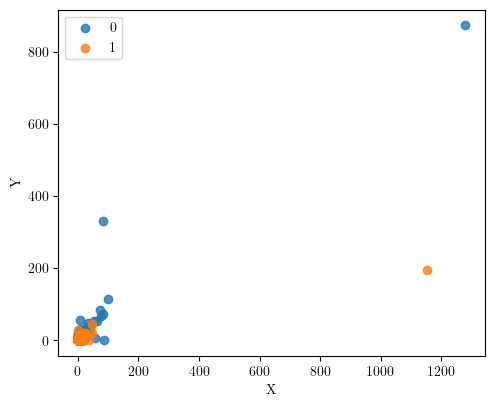

Oversampling statistics in training set: 
Normal Consumers:                     21627
Consumers with Fraud:                 21627
Total Consumers                       43254
Counter({1: 1109, 0: 1054})


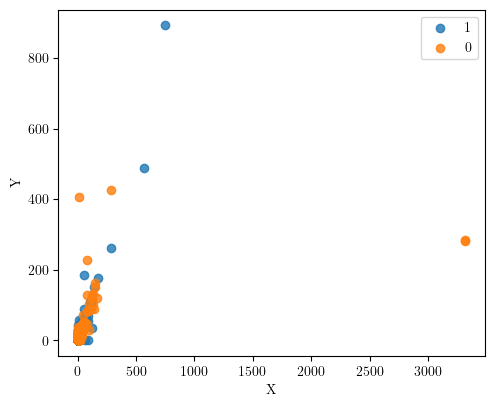

In [110]:
def SMOTE_Eval(A,B,pre):
    y_trainWS=B.sample(frac=0.05)
    X_trainWS=A.sample(frac=0.075)
    # summarize class distribution
    counter = Counter(y_trainWS)
    print(counter)
    # scatter plot of examples by class label
    pyplot.figure(figsize=(5.5,4.5))

    for label, _ in counter.items():
        row_ix = where(y_trainWS == label)[0]
        pyplot.scatter(X_trainWS.iloc[row_ix, 0], X_trainWS.iloc[row_ix, 1], label=str(label), alpha=0.8)
    pyplot.xlabel('X')
    pyplot.ylabel('Y')
    pyplot.legend()
    # pyplot.savefig(pre+'_smote.png',dpi=200)
    pyplot.show()

# Definition of functions
def read_data(test_set_size=0.2):
    rawData = pd.read_csv('../data/processed_data.csv')

    # Setting the target and dropping the unnecessary columns
    y = rawData[['FLAG']]
    X = rawData.drop(['FLAG', 'CONS_NO'], axis=1)

    print('Normal Consumers:                    ', y[y['FLAG'] == 0].count()[0])
    print('Consumers with Fraud:                ', y[y['FLAG'] == 1].count()[0])
    print('Total Consumers:                     ', y.shape[0])
    print("Classification assuming no fraud:     %.2f" % (y[y['FLAG'] == 0].count()[0] / y.shape[0] * 100), "%")

    # columns reindexing according to dates
    X.columns = pd.to_datetime(X.columns)
    X = X.reindex(X.columns, axis=1)
    
    # Splitting the dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y['FLAG'], train_size=0.75, random_state=1999)
    print("Test set assuming no fraud:           %.2f" % (y_test[y_test == 0].count() / y_test.shape[0] * 100), "%\n")
    SMOTE_Eval(X_train,y_train,'without')
    # Oversampling of minority class to encounter the imbalanced learning
    if oversampling_flag == 1:
        over = SMOTE(random_state=1994)
        # over = KMeansSMOTE(kmeans_estimator=MiniBatchKMeans(n_init=1, n_clusters=380, random_state=0), random_state=1999)
        undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=1999)
        
        X_train, y_train = over.fit_resample(X_train, y_train)
        # X_train, y_train = undersampler.fit_resample(X_train, y_train)
#         X_test, y_test = over.fit_resample(X_test, y_test)
        print("Oversampling statistics in training set: ")
        print('Normal Consumers:                    ', y_train[y_train == 0].count())
        print('Consumers with Fraud:                ', y_train[y_train == 1].count())
        print("Total Consumers                      ", X_train.shape[0])
    SMOTE_Eval(X_train,y_train,'with')
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test=read_data()

In [10]:
X_train

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,3.140000,2.940000,2.270000,3.550000,3.410000,3.080000,3.260000,3.110000,3.300000,2.930000,...,1.720000,1.510000,1.650000,1.720000,1.820000,2.180000,1.980000,1.810000,1.560000,1.820000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.010000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,8.390000,9.030000,8.430000,8.500000,7.990000,7.810000,7.140000,6.200000,9.920000,7.960000,...,7.730000,10.030000,5.570000,5.600000,6.050000,6.000000,4.990000,9.900000,10.700000,5.250000
3,5.750000,5.680000,4.450000,4.310000,4.880000,4.770000,4.670000,3.110000,4.910000,4.150000,...,0.140000,0.110000,0.150000,0.150000,0.150000,0.150000,0.160000,0.150000,0.150000,0.150000
4,2.890000,7.960000,7.790000,8.040000,7.370000,9.300000,17.030000,12.480000,16.960000,15.910000,...,5.660000,6.090000,13.670000,14.180000,6.290000,6.570000,5.360000,12.500000,6.330000,12.970000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,128.981328,129.872661,126.839361,125.373335,126.642111,121.672026,122.373299,124.567471,123.160317,121.589486,...,200.441470,203.369683,183.959892,183.452784,188.463543,186.821971,190.553795,174.139430,174.061105,170.719806
29960,70.589891,275.610643,288.666353,287.568694,225.709010,231.210848,246.304800,284.781857,261.562032,227.481519,...,515.407561,393.144656,484.008997,514.600121,503.318317,446.390926,427.200025,375.834233,287.517170,456.165092
27144,143.287661,130.579239,132.508954,133.301024,138.128854,128.435925,129.897463,125.548834,132.754567,132.594526,...,214.226242,222.333503,182.150091,185.349091,191.752244,196.684098,195.889532,188.555572,180.076916,180.556273
33446,122.398909,124.295779,125.553239,124.634148,122.532745,122.377092,122.434440,125.363643,122.057692,122.040833,...,202.445599,202.271241,184.463935,187.079214,191.952616,191.527956,193.100435,183.174126,176.750610,180.572102


## SMOTE balancing
work with outliner data

In [53]:
cleaned_df = pd.read_csv('../data/new_clean_data2.csv')
cleaned_df.drop(['Unnamed: 0'], axis=1, inplace=True)
cleaned_df

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
2,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
3,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
4,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31678,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
31679,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
31680,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,5.68,4.39,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
31681,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,1.23,0.84,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65


### VISUALIZE

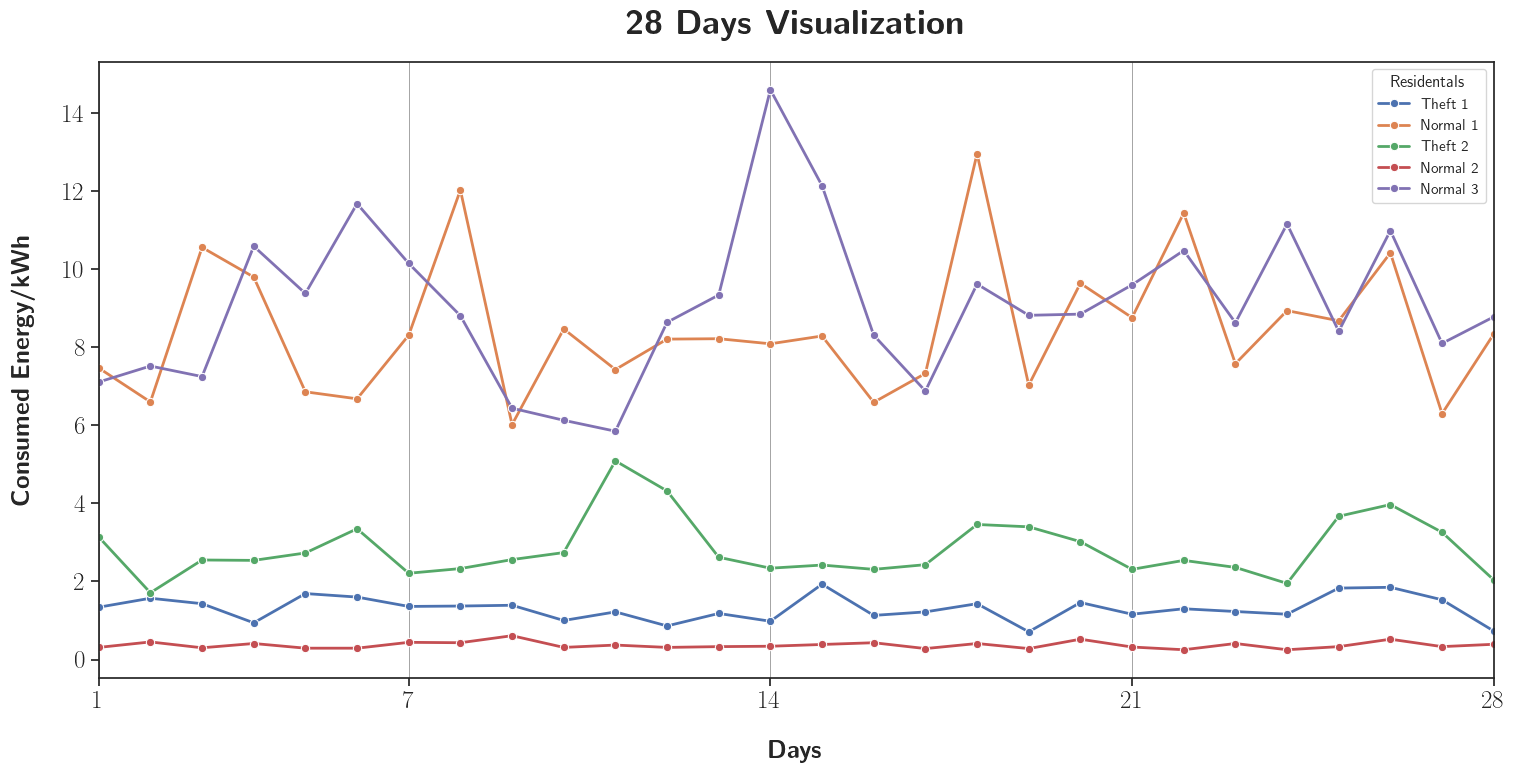

In [57]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd

mpl.rcParams.update(mpl.rcParamsDefault)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.weight": "bold"
})

# rows = [cleaned_df.iloc[0, 0:28] for _ in range(5)]
# Assuming df is your DataFrame and you want to visualize the first row
rows = cleaned_df.iloc[[7, 2590, 10, 3617, 26723], 280:308]
# rows = [cleaned_df.iloc[2609, 0+28*i:28*i+28] for i in range(1, 10)]

# Flatten the list of rows
flat_values = np.array(rows).flatten()

# Create a new DataFrame for the selected data
data = pd.DataFrame({
    'Day': list(range(1, 29)) * len(rows),
    'Value': flat_values,
    # 'Residentals': [f'Residental {i+1}' for i in range(len(rows)) for _ in range(28)]
    'Residentals': np.array([["Theft 1" for _ in range(28)], ["Normal 1" for _ in range(28)], ["Theft 2" for _ in range(28)], ["Normal 2" for _ in range(28)], ["Normal 3" for _ in range(28)]]).flatten().tolist()
})


# Set a theme
# sns.axes_style()
sns.set_theme(style="ticks")

# Create a lineplot
plt.figure(figsize=(18, 8))

sns.lineplot(x='Day', y='Value', hue='Residentals', data=data, linewidth=2, marker='o')

# Define the markers
# markers = ['o', 'v', '^', '<', '>']

# Get the unique residentals
# residentals = data['Residentals'].unique()

# Create a lineplot for each residental
# for i, residental in enumerate(residentals):
#     df_residental = data[data['Residentals'] == residental]
#     sns.lineplot(x='Day', y='Value', data=df_residental, marker=markers[i % len(markers)], linewidth=2)

# Add title and labels
plt.title(r'\textbf{28 Days Visualization}', fontsize=25, pad=20)
plt.xlabel(r'\textbf{Days}', fontsize=18, labelpad=20)
plt.ylabel(r'\textbf{Consumed Energy/kWh}', fontsize=18, labelpad=20)

# Set xticks to only show the first and last day
plt.xticks([0, 1, 7, 14, 21, 28], fontsize=18)
plt.yticks(fontsize=18)

# Get the current axes, enabling you to manipulate its properties
ax = plt.gca()

# Display only vertical gridlines
ax.grid(True, which='both', axis='x', color='gray', linewidth=0.5)

# Set x-axis limits
plt.xlim(1, 28)

# Show the plot
plt.show()

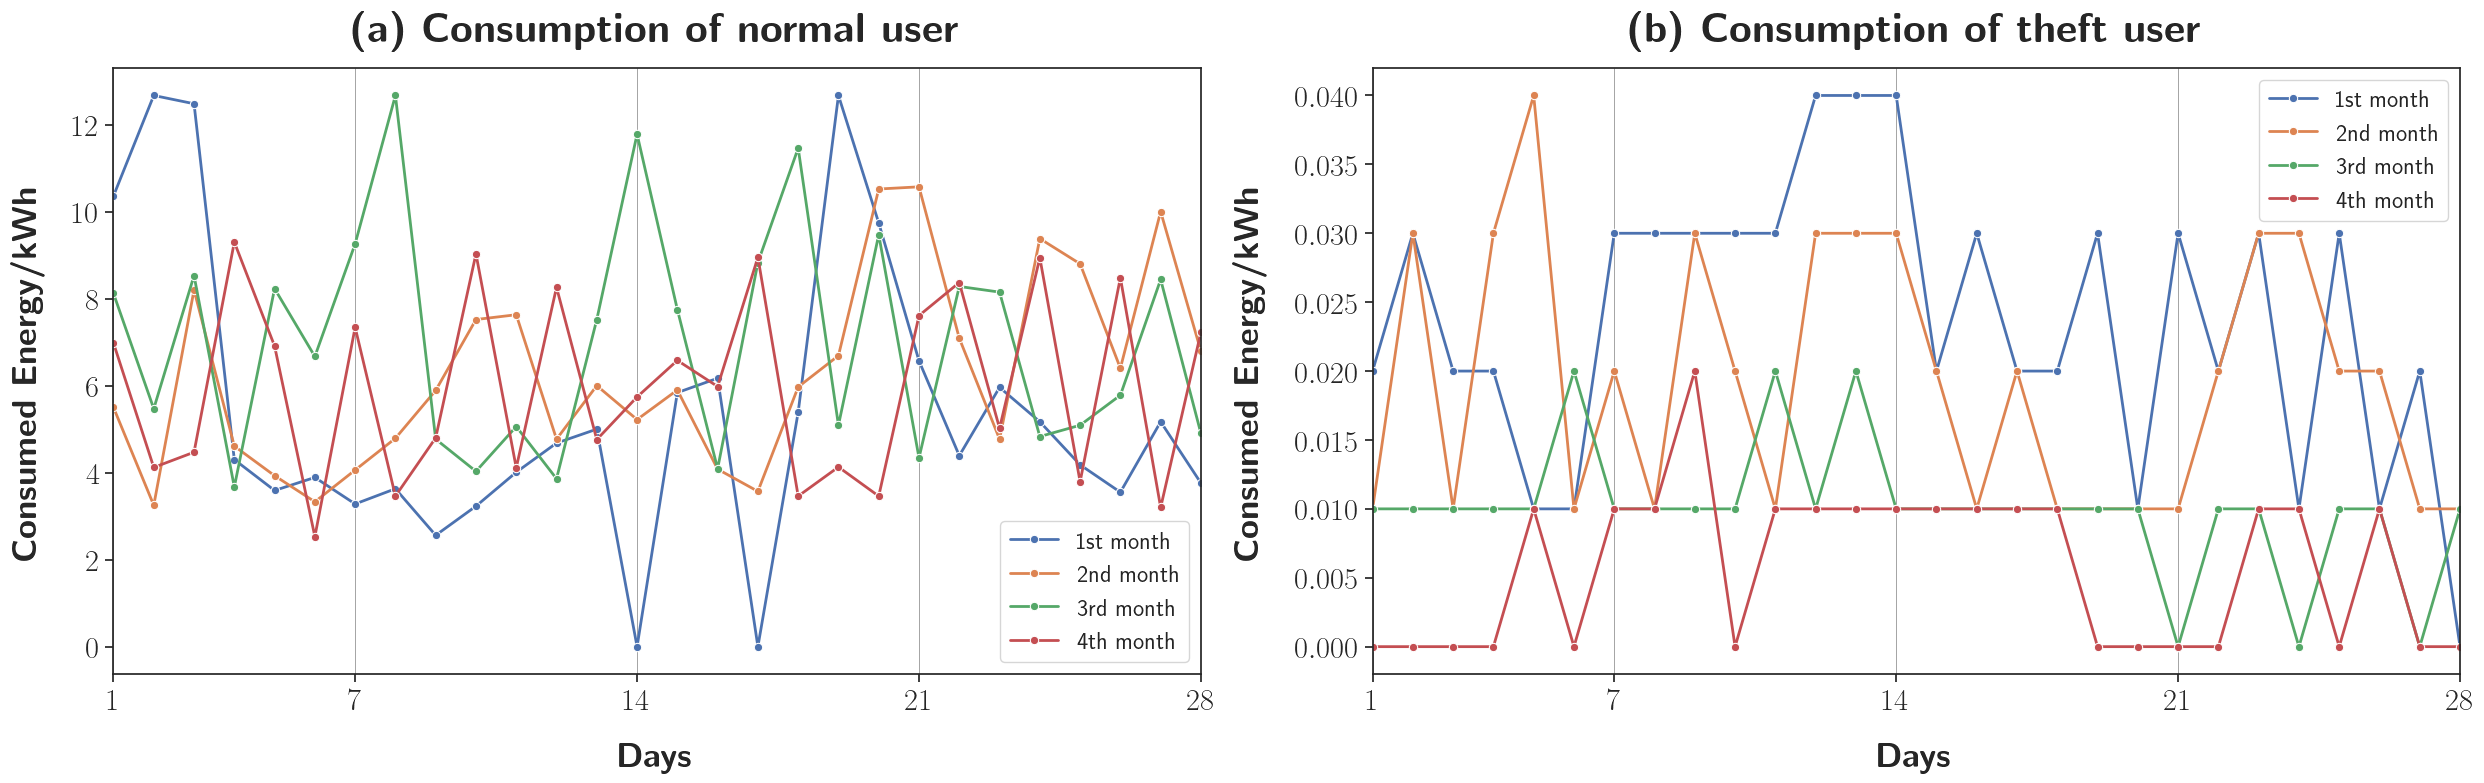

In [202]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

mpl.rcParams.update(mpl.rcParamsDefault)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"
})

sns.set_theme(style="ticks")

# Assuming df is your DataFrame and you want to visualize the first row
rows = [cleaned_df.iloc[8976, 0+28*i:28*i+28] for i in range(1, 5)]

# Flatten the list of rows
flat_values = np.array(rows).flatten()

# Create a new DataFrame for the selected data
data = pd.DataFrame({
    'Day': list(range(1, 29)) * len(rows),
    'Value': flat_values,
    # 'Residentals': [f'Residental {i+1}' for i in range(len(rows)) for _ in range(28)]
    'Residentals': np.array([["1st month" for _ in range(28)], ["2nd month" for _ in range(28)], ["3rd month" for _ in range(28)], ["4th month" for _ in range(28)]]).flatten().tolist()
})

# Create a figure with 2 subplots
fig, axs = plt.subplots(1, 2, figsize=(25, 8))

# Create the first lineplot
sns.lineplot(x='Day', y='Value', hue='Residentals', data=data, linewidth=2, marker='o', ax=axs[0])
axs[0].set_title(r'\textbf{(a) Consumption of normal user}', fontsize=30, pad=20)
axs[0].set_xlabel(r'\textbf{Days}', fontsize=25, labelpad=20)
axs[0].set_ylabel(r'\textbf{Consumed Energy/kWh}', fontsize=25, labelpad=20)
axs[0].set_xticks([0, 1, 7, 14, 21, 28])
axs[0].tick_params(axis='both', which='major', labelsize=22) 
axs[0].grid(True, which='both', axis='x', color='gray', linewidth=0.5)
axs[0].set_xlim(1, 28)
axs[0].legend(fontsize='x-large')  # Change font size of legend

# Assuming df is your DataFrame and you want to visualize the first row
rows = [cleaned_df.iloc[100, 0+28*i:28*i+28] for i in range(1, 5)]

# Flatten the list of rows
flat_values = np.array(rows).flatten()

# Create a new DataFrame for the selected data
data = pd.DataFrame({
    'Day': list(range(1, 29)) * len(rows),
    'Value': flat_values,
    # 'Residentals': [f'Residental {i+1}' for i in range(len(rows)) for _ in range(28)]
    'Residentals': np.array([["1st month" for _ in range(28)], ["2nd month" for _ in range(28)], ["3rd month" for _ in range(28)], ["4th month" for _ in range(28)]]).flatten().tolist()
})

# Create the second lineplot
# (replace 'data2' with your second DataFrame)
sns.lineplot(x='Day', y='Value', hue='Residentals', data=data, linewidth=2, marker='o', ax=axs[1])
axs[1].set_title(r'\textbf{(b) Consumption of theft user}', fontsize=30, pad=20)
axs[1].set_xlabel(r'\textbf{Days}', fontsize=25, labelpad=20)
axs[1].set_ylabel(r'\textbf{Consumed Energy/kWh}', fontsize=25, labelpad=20)
axs[1].set_xticks([0, 1, 7, 14, 21, 28])
axs[1].tick_params(axis='both', which='major', labelsize=22) 
axs[1].grid(True, which='both', axis='x', color='gray', linewidth=0.5)
axs[1].set_xlim(1, 28)
axs[1].legend(fontsize='x-large')  # Change font size of legend

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
np.array([["Theft 1" for _ in range(28)], ["Normal 1" for _ in range(28)], ["Theft 2" for _ in range(28)], ["Normal 2" for _ in range(28)], ["Normal 3" for _ in range(28)]]).flatten()

In [54]:
flag = pd.read_csv('../data/new_info2.csv')
flag.drop(['Unnamed: 0'], axis=1, inplace=True)
flag

,FLAG,CONS_NO
0,1,0387DD8A07E07FDA6271170F86AD9151
1,1,B32AC8CC6D5D805AC053557AB05F5343
2,1,EDFC78B07BA2908B3395C4EB2304665E
3,1,34C1954AA3703C4F8BD8EAEA7C4B7B83
4,1,768309B0EB11FD436CEE5ABFB84F4C0C
...,...,...
31678,0,5FCE503B6B616D5023B3C46173383107
31679,0,F1472871E1AFF49D4289564B6377D76C
31680,0,F3C8BBCD2DC26C1E0249DEEF6A4256B7
31681,0,A9A0FE83467A680FBFB0DBFC910DF227


In [55]:
df_combined = pd.concat([flag, cleaned_df], axis=1)
df_combined

,FLAG,CONS_NO,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,1,0387DD8A07E07FDA6271170F86AD9151,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,1,B32AC8CC6D5D805AC053557AB05F5343,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
2,1,EDFC78B07BA2908B3395C4EB2304665E,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
3,1,34C1954AA3703C4F8BD8EAEA7C4B7B83,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
4,1,768309B0EB11FD436CEE5ABFB84F4C0C,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31678,0,5FCE503B6B616D5023B3C46173383107,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
31679,0,F1472871E1AFF49D4289564B6377D76C,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
31680,0,F3C8BBCD2DC26C1E0249DEEF6A4256B7,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
31681,0,A9A0FE83467A680FBFB0DBFC910DF227,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65


In [56]:
sampling_df = df_combined.copy(deep=True)

# Non sampling

In [77]:
# no balancing
x = sampling_df.iloc[:, 2:].values
y = sampling_df.iloc[:, 0].values

resample = pd.DataFrame(x)
print(resample.shape)
resample.head()

(31683, 1034)


,0,1,2,3,4,5,6,7,8,9,...,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
2,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
3,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
4,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91


## SMOTE

In [57]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import KMeansSMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.cluster import MiniBatchKMeans

def undersampling(X, y, ratio=1.0, choice=1):
    # Count of number of samples in each class
    class_counts = Counter(y)

    # Determining the class with fewer samples
    minority_class = min(class_counts, key=class_counts.get)
    majority_class = max(class_counts, key=class_counts.get)

    # Creating SMOTE and Undersampler instances with the specified ratio
    undersampler = RandomUnderSampler(sampling_strategy=ratio, random_state=42)
    
    if choice == 0:
        print("Using SMOTE")
        smote = SMOTE(sampling_strategy=ratio, random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X, y)
    elif choice == 1:
        print("Using ADASYN")
        adasyn = ADASYN(sampling_strategy=ratio, random_state=42)
        X_resampled, y_resampled = adasyn.fit_resample(X, y)
    else: 
        print("Using KMeansSMOTE")
        kmean_sm = KMeansSMOTE(kmeans_estimator=MiniBatchKMeans(n_init=1, random_state=0), random_state=42)
        X_resampled, y_resampled = kmean_sm.fit_resample(X, y)
        
        
    # Applying undersampling to reduce the number of samples in the majority class
    X_resampled, y_resampled = undersampler.fit_resample(X_resampled, y_resampled)

    # Counting the number of samples in each class in the final resampled dataset
    final_class_counts = Counter(y_resampled)

    return X_resampled, y_resampled, final_class_counts

desired_ratio = 1.0
# SEPARATING DEPENDENT AND INDEPENDENT VARIABLES
x = sampling_df.iloc[:, 2:].values
y = sampling_df.iloc[:, 0].values
print("Shape of x:", x.shape)
print("Shape of y:", y.shape)

x_resampled, y_resampled, final_class_counts = undersampling(x, y, ratio=desired_ratio, choice=2)

# The final_class_counts will now contain equal numbers of samples for both classes
print("Final class counts:", final_class_counts)

Shape of x: (31683, 1034)
Shape of y: (31683,)
Using KMeansSMOTE
Final class counts: Counter({0: 29151, 1: 29151})


In [58]:
import numpy as np

# Assuming y_resampled is a numpy array
count_zero = np.count_nonzero(y_resampled == 0)
print("Count of 0 in y_resampled:", count_zero)

Count of 0 in y_resampled: 29151


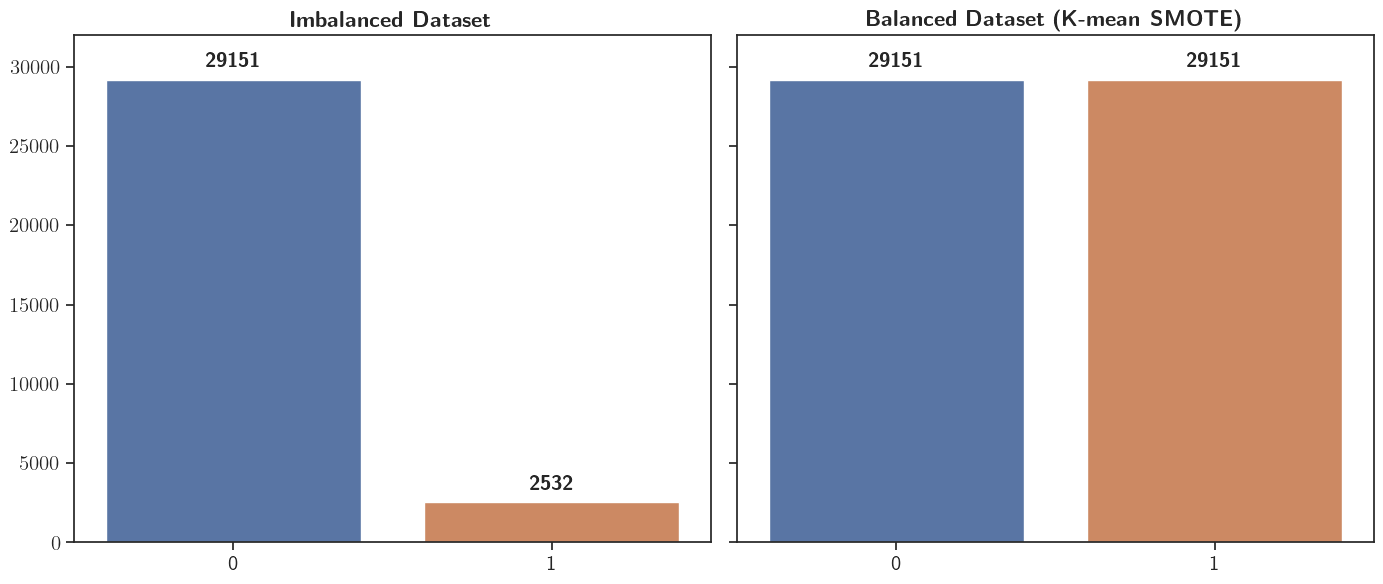

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample data
data_imbalanced = {'Class': [0]*flag[flag['FLAG'] == 0].shape[0] + [1]*flag[flag['FLAG'] == 1].shape[0]}
count_zero = np.count_nonzero(y_resampled == 0)
data_balanced = {'Class': [0]*count_zero + [1]*(len(y_resampled) - count_zero)}


df_imbalanced = pd.DataFrame(data_imbalanced)
df_balanced = pd.DataFrame(data_balanced)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Imbalanced dataset plot
sns.countplot(x='Class', data=df_imbalanced, ax=axs[0], palette='deep')
axs[0].set_title(r'\textbf{Imbalanced Dataset}', fontsize=16)
axs[0].set_xlabel('')
axs[0].set_ylabel('')
axs[0].tick_params(axis='both', labelsize=15)
axs[0].set_ylim(0, 32000)

# Add count values on top of each bar
for p in axs[0].patches:
    height = p.get_height()
    axs[0].text(p.get_x()+p.get_width()/2., height + 0.1*8000, r'\textbf{{{}}}'.format(int(height)), ha="center", fontsize=15) 

# Balanced dataset plot
sns.countplot(x='Class', data=df_balanced, ax=axs[1], palette='deep')
axs[1].set_title(r'\textbf{Balanced Dataset (K-mean SMOTE)}', fontsize=16)
axs[1].set_xlabel('')
axs[1].set_ylabel('')
axs[1].tick_params(axis='both', labelsize=15)

# Add count values on top of each bar
for p in axs[1].patches:
    height = p.get_height()
    axs[1].text(p.get_x()+p.get_width()/2., height + 0.1*8000, r'\textbf{{{}}}'.format(int(height)), ha="center", fontsize=15) 

plt.tight_layout()
plt.show()

In [59]:
x

array([[ 0.  ,  0.  ,  0.  , ...,  7.54,  9.16,  6.74],
       [ 0.  ,  0.  ,  0.  , ..., 19.26, 14.46, 11.72],
       [ 2.9 ,  5.64,  6.99, ..., 10.89,  9.86,  8.72],
       ...,
       [ 2.7 ,  0.  ,  0.  , ...,  6.22,  6.05,  4.77],
       [ 0.58,  1.16,  0.92, ...,  0.66,  0.39,  0.65],
       [16.89, 15.15, 19.28, ..., 13.16, 13.33, 10.39]])

In [79]:
# no balancing

resample = pd.DataFrame(x)
print(resample.shape)
resample.head()

(31683, 1034)


,0,1,2,3,4,5,6,7,8,9,...,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
2,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
3,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,0.23,0.53,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
4,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,1.17,0.86,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91


In [60]:
# Blancing 2

print(y_train.shape)
X_traindf = pd.DataFrame(X_train)
X_testdf = pd.DataFrame(X_test)
X_testdf.head()

(43254,)


,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
14841,0.000,2.18,2.330,2.05,3.590,2.830,2.350,2.600,1.74,1.890,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.03,0.01
16529,30.800,19.37,18.950,17.84,15.310,15.240,18.390,17.320,29.06,16.380,...,26.29,11.78,14.85,15.34,15.80,18.71,14.72,15.21,13.62,16.61
6655,0.865,2.33,2.135,1.63,1.450,2.005,1.795,0.865,0.27,0.210,...,0.00,0.00,0.00,0.00,0.00,0.00,1.41,1.18,2.29,1.99
3691,3.940,3.10,0.000,5.37,0.000,3.400,0.000,0.000,5.84,6.080,...,4.45,3.08,4.46,4.73,6.33,3.88,4.31,7.11,6.00,6.76
18071,0.740,0.65,0.585,0.66,0.655,0.660,0.615,0.575,0.59,0.845,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [63]:
print(y_resampled.shape)
resample = pd.DataFrame(x_resampled)
resample.head()

(58302,)


,0,1,2,3,4,5,6,7,8,9,...,1024,1025,1026,1027,1028,1029,1030,1031,1032,1033
0,7.48,12.84,12.02,16.50,15.89,7.94,13.61,10.79,10.59,9.2,...,14.58,13.250000,11.52,9.50,14.02,14.21,13.64,10.32,16.320000,12.190000
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,...,8.53,6.770000,6.27,3.68,2.28,4.86,7.02,5.55,3.770000,6.920000
3,0.00,9.15,0.00,10.41,0.00,0.00,0.00,11.43,0.00,0.0,...,10.22,22.362649,15.82,13.31,12.98,15.32,12.39,16.34,22.362649,22.362649
4,0.00,0.00,0.00,11.43,0.00,0.00,0.00,11.60,0.00,0.0,...,4.81,5.210000,4.10,4.53,5.77,4.86,6.45,7.53,6.320000,5.500000


## Continue split data

In [61]:
X_traindf['data'] = X_traindf[X_traindf.columns].values.tolist()
df_train = X_traindf['data']
X_testdf['data'] = X_testdf[X_testdf.columns].values.tolist()
df_test = X_testdf['data']
df_train

/tmp/ipykernel_122920/3326708882.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_traindf['data'] = X_traindf[X_traindf.columns].values.tolist()


0        [3.14, 2.94, 2.27, 3.55, 3.41, 3.08, 3.26, 3.1...
1        [0.0, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0,...
2        [8.39, 9.03, 8.43, 8.5, 7.99, 7.81, 7.14, 6.2,...
3        [5.75, 5.68, 4.45, 4.31, 4.88, 4.77, 4.67, 3.1...
4        [2.89, 7.96, 7.79, 8.04, 7.37, 9.3, 17.03, 12....
                               ...                        
24995    [128.98132836537914, 129.87266107699978, 126.8...
29960    [70.58989140964081, 275.6106432359518, 288.666...
27144    [143.28766096469155, 130.5792386188579, 132.50...
33446    [122.39890901597346, 124.29577941756942, 125.5...
39025    [101.47233041219947, 76.96866734232124, 75.611...
Name: data, Length: 43254, dtype: object

In [64]:
#df_pr['data'] = df_pr[df_pr.columns].astype(float).values.tolist()
resample['data'] = resample[resample.columns].values.tolist()
df_apr = resample['data']
df_apr

0        [7.48, 12.84, 12.02, 16.5, 15.89, 7.94, 13.61,...
1        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3        [0.0, 9.15, 0.0, 10.41, 0.0, 0.0, 0.0, 11.43, ...
4        [0.0, 0.0, 0.0, 11.43, 0.0, 0.0, 0.0, 11.6, 0....
                               ...                        
58297    [25.324620296091673, 23.613497303112506, 20.53...
58298    [200.1922938667828, 211.95957116507265, 186.26...
58299    [2.38, 3.24, 3.97, 3.66, 2.58, 3.58, 3.78, 3.6...
58300    [2376.853456397411, 616.063595530886, 883.0768...
58301    [73.41703318520813, 81.22196210810982, 72.7717...
Name: data, Length: 58302, dtype: object

In [111]:
import torch.nn.functional as F

window_size = 28 # 4weeks
output_shape = (1036 // window_size, window_size)
print(output_shape)
strided_size = output_shape[0]
print(strided_size)

# padded_arr = np.pad(arr, (0, 1089 - len(arr)), 'constant')
# matrix1 = padded_arr.reshape(33, 33)

# print(np.arange(20))
# np.lib.stride_tricks.as_strided(np.arange(30), (6,5), (8*5, 8))

def stride(x):
    as_strided = np.lib.stride_tricks.as_strided
    # x = pd.Series(x) # no padding
    # print(len(x)) 1034 
    x = np.pad(pd.Series(x), (0, 2), 'constant') # padding 
    return as_strided(x, output_shape, (8*window_size, 8))

data_train = df_train.apply(stride)
data_test = df_test.apply(stride)

data_train

(37, 28)
37


ValueError: Per-column arrays must each be 1-dimensional

In [82]:
# NO BALANCING

df_dpr = data.to_frame()
df_dpr['label'] = y
df_dpr.shape

(31683, 2)

In [66]:
df_train = data_train.to_frame()
df_train['label'] = y_train

df_test = data_test.to_frame()
df_test['label'] = y_test

print("Train data shape: ", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape:  (43254, 2)
Test data shape:  (7839, 2)


In [ ]:
df_dpr = data.to_frame()
df_dpr['label'] = y_resampled
df_dpr.shape

In [68]:
data_dir = '../data'
save_file_train = f'{data_dir}/ksm_trans_reimplement_train.npz'
save_file_test = f'{data_dir}/ksm_trans_reimplement_test.npz'

print('Saving to: ', save_file_train)
data = df_train['data']
label = df_train['label']
np.savez_compressed(save_file_train, data=data, label=label)

print('Saving to: ', save_file_test)
data = df_test['data']
label = df_test['label']
np.savez_compressed(save_file_test, data=data, label=label)


Saving to:  ../data/ksm_trans_reimplement_train.npz
Saving to:  ../data/ksm_trans_reimplement_test.npz


In [ ]:
data_dir = '../data'
save_file = f'{data_dir}/ksm_30stride_transformer.npz'
print('Saving to: ', save_file)
data = df_dpr['data']
label = df_dpr['label']
np.savez_compressed(save_file, data=data, label=label)

In [71]:
np.random.seed(0)

class Writer:
    def __init__(self, outdir, type_name, start_idx=0,):
        self.outdir = Path(outdir)/ type_name
        self.outdir.mkdir(parents=True, exist_ok=True)
        self.idx = start_idx
    def write(self, X, y):
        save_file = self.outdir / f'{self.idx}.npz'
        np.savez_compressed(save_file, X=X, y=y)
        self.idx += 1
    def start(self):
        print('Start writing to: ', self.outdir)

def write_to_file(writer, X, y):
    writer.start()
    try:
        for xi, yi in tqdm(zip(X, y)):
            writer.write(xi, yi)
    except: return False
    return True

def train_test_split(N, test_fraction):
    """
    Input: 
    N: the size of the dataset
    test_fraction: the portion for test set
    Output:
    Return the index for train, val, and test set
    """
    test_size = int(N * test_fraction)
    indices = np.random.permutation(N) 
    test_idx = indices[:test_size]
    train_idx = indices[test_size:]
    return [train_idx, test_idx]

def create_folder_from_npz_file(out_dir, dir_type, fn):
    file_name = Path(data_dir) / fn
    print('Loading from: ', file_name)
    
    df_np = np.load(file_name, allow_pickle=True)
    print(df_np.files)
    
    data, label = df_np['data'], df_np['label']
    print(len(data), len(label))
    
    np.set_printoptions(threshold=np.inf)
    print(data[0])

    out_path = out_dir  
    writer = Writer(outdir=out_path, type_name=f'{dir_type}')
    return write_to_file(writer, data, label)

np.set_printoptions(suppress=True)

out_dir = '../data/ksm_30stride/'
create_folder_from_npz_file(out_dir=out_dir, dir_type='train', fn='ksm_trans_reimplement_train.npz')
create_folder_from_npz_file(out_dir=out_dir, dir_type='val', fn='ksm_trans_reimplement_test.npz')

Loading from:  ../data/ksm_trans_reimplement_train.npz
['data', 'label']
43254 43254
[[3.14       2.94       2.27       3.55       3.41       3.08
  3.26       3.11       3.3        2.93       2.9        3.6
  3.15       3.42       2.69       5.12       3.4        3.01
  2.69       3.44       3.39       3.11       3.47       1.97
  2.14       2.34       3.43       3.58       3.5        5.31348595]
 [3.12       3.47       3.12       1.61       3.31       2.13
  4.48       2.22       2.14       2.32       3.43       2.95
  1.92       2.29       3.92       2.44       1.98       2.22
  2.46       1.81       2.13       0.9        1.98       2.06
  2.64       2.19       2.53       2.25       2.13       1.53      ]
 [2.36       2.12       1.96       3.88       2.04       1.3
  0.92       1.02       1.91       2.06       2.06       1.99
  2.08       3.15       3.14       3.04       4.96       3.41
  3.38       3.19       3.05       3.35       3.27       3.32
  3.57       1.48       2.62       

43254it [00:21, 2058.38it/s]


Loading from:  ../data/ksm_trans_reimplement_test.npz
['data', 'label']
7839 7839
[[0.         2.18       2.33       2.05       3.59       2.83
  2.35       2.6        1.74       1.89       1.78       2.14
  2.06       1.77       2.74       2.74       2.25       2.71
  1.64       1.89       2.51       2.42       2.84       3.19
  3.8        2.29       2.09       2.4        2.13       5.        ]
 [3.19       3.94       2.86       3.01       2.72       2.67
  2.49       2.65       4.13       2.78       3.25       3.01
  1.94       3.04       4.84       4.27       2.63       2.18
  3.87       2.26       2.53       4.14       2.76       1.83
  2.21       2.24       2.9        2.99       2.34       4.02      ]
 [2.61       1.83       2.71       1.7        2.72       2.2
  3.24       3.01       2.44       3.37       3.32       3.16
  2.58       1.92       2.45       2.84       3.26       2.73
  2.65       3.1        2.32       2.12       2.71       2.57
  2.33       3.68       3.8        2.

7839it [00:04, 1748.40it/s]


True

In [84]:
np.random.seed(0)

class Writer:
    def __init__(self, outdir, type_name, start_idx=0,):
        self.outdir = Path(outdir)/ type_name
        self.outdir.mkdir(parents=True, exist_ok=True)
        self.idx = start_idx
    def write(self, X, y):
        save_file = self.outdir / f'{self.idx}.npz'
        np.savez_compressed(save_file, X=X, y=y)
        self.idx += 1
    def start(self):
        print('Start writing to: ', self.outdir)

def write_to_file(writer, X, y):
    writer.start()
    try:
        for xi, yi in tqdm(zip(X, y)):
            writer.write(xi, yi)
    except: return False
    return True

def train_test_split(N, test_fraction):
    """
    Input: 
    N: the size of the dataset
    test_fraction: the portion for test set
    Output:
    Return the index for train, val, and test set
    """
    test_size = int(N * test_fraction)
    indices = np.random.permutation(N) 
    test_idx = indices[:test_size]
    train_idx = indices[test_size:]
    return [train_idx, test_idx]

def create_folder_from_npz_file(out_dir, dir_type, fn):
    file_name = Path(data_dir) / fn
    print('Loading from: ', file_name)
    df_np = np.load(file_name, allow_pickle=True)
    print(df_np.files)
    data, label = df_np['data'], df_np['label']
    print(len(data), len(label))
    np.set_printoptions(threshold=np.inf)
    print(data[0])
    
    indices_lists = train_test_split(len(data), test_fraction=0.2) 
    prefix = ['train', 'val']
    
    for prefix, indices in zip(prefix, indices_lists):
        if prefix == dir_type:
            print(f'{prefix} size: ', len(indices))
            data_subset = data[indices] 
            label_subset = label[indices]

    out_path = out_dir  
    writer = Writer(outdir=out_path, type_name=f'{dir_type}')
    return write_to_file(writer, data_subset, label_subset)

np.set_printoptions(suppress=True)

out_dir = '../data/non_ksm_transformer/'
create_folder_from_npz_file(out_dir=out_dir, dir_type='train', fn='non_ksm_transformer.npz')
create_folder_from_npz_file(out_dir=out_dir, dir_type='val', fn='non_ksm_transformer.npz')

Loading from:  ../data/non_ksm_transformer.npz
['data', 'label']
31683 31683
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          4.15        8.3         7.57
   7.01        7.61        8.1         4.54        7.78        8.57
   6.41        6.68        7.15        6.          5.02        6.89
   6.91        8.26        5.55        5.37        4.72        6.56
   4.94        7.89  

25347it [00:13, 1924.68it/s]


Loading from:  ../data/non_ksm_transformer.npz
['data', 'label']
31683 31683
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          4.15        8.3         7.57
   7.01        7.61        8.1         4.54        7.78        8.57
   6.41        6.68        7.15        6.          5.02        6.89
   6.91        8.26        5.55        5.37        4.72        6.56
   4.94        7.89  

6336it [00:03, 1881.90it/s]


True